In [84]:
import pandas as pd
import pingouin as pg
import time
from scipy import stats
from tqdm import tqdm
import numpy as np
from pathlib import Path
import snf
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score
import networkx as nx

In [39]:
base = "C:/Users/colombelli/Desktop/TCC/data/TCGA/BRCA/"
df = pd.read_csv(base+"BRCA_mRNA.csv", index_col=0)

statspandas.DataFrame
'X': Name(s) of first columns.

'Y': Name(s) of second columns.

'method': Correlation type.

'covar': List of specified covariate(s), only when covariates are passed.

'alternative': Tail of the test.

'n': Sample size (after removal of missing values).

'r': Correlation coefficients.

'CI95': 95% parametric confidence intervals.

'p-unc': Uncorrected p-values.

'p-corr': Corrected p-values.

'p-adjust': P-values correction method.

'BF10': Bayes Factor of the alternative hypothesis (only for Pearson correlation)

'power': achieved power of the test (= 1 - type II error).

#### Pingouin didn't work, took way too much to calculate what i needed

In [ ]:
start = time.perf_counter()
corr_df = pg.pairwise_corr(df.iloc[:10, :], padjust='bonf')
end = time.perf_counter()

print("Time taken: ", end-start)

In [ ]:
start = time.perf_counter()
corr_df_none = pg.pairwise_corr(df, padjust='none')
end = time.perf_counter()

print("Time taken: ", end-start)

In [ ]:
start = time.perf_counter()
corr_df_100 = pg.pairwise_corr(df.iloc[0:100, :], padjust='bonf')
end = time.perf_counter()

print("Time taken: ", end-start)

#### Trying to calculate by hand, making an edge list like dataframe

In [19]:
dt = df.T

col_1 = []
col_2 = []
col_r = []
col_p = []

for idx1, row1 in tqdm(dt.iterrows(), total=dt.shape[0]):
    for idx2, row2 in dt.loc[idx1:, :].iterrows():
        r, p = stats.pearsonr(row1.values, row2.values)
        col_1.append(idx1)
        col_2.append(idx2)
        col_r.append(r)
        col_p.append(p)

100%|████████████████████████████████████████████████████████████████████████████████| 759/759 [00:22<00:00, 34.43it/s]


In [20]:
corr_df = pd.DataFrame.from_dict({
        "sample1": col_1,
        "sample2": col_2,
        "r": col_r,
        "p": col_p
    })

In [21]:
corr_df

,sample1,sample2,r,p
0,TCGA.3C.AAAU.01,TCGA.3C.AAAU.01,1.000000,0.000000e+00
1,TCGA.3C.AAAU.01,TCGA.3C.AALI.01,0.011027,6.221119e-01
2,TCGA.3C.AAAU.01,TCGA.3C.AALJ.01,0.161264,4.018140e-13
3,TCGA.3C.AAAU.01,TCGA.3C.AALK.01,-0.167896,4.107702e-14
4,TCGA.3C.AAAU.01,TCGA.5L.AAT0.01,-0.124918,2.082677e-08
...,...,...,...,...
288415,TCGA.XX.A89A.01,TCGA.Z7.A8R5.01,0.141578,2.021889e-10
288416,TCGA.XX.A89A.01,TCGA.Z7.A8R6.01,-0.225851,1.509051e-24
288417,TCGA.Z7.A8R5.01,TCGA.Z7.A8R5.01,1.000000,0.000000e+00
288418,TCGA.Z7.A8R5.01,TCGA.Z7.A8R6.01,-0.284133,1.881507e-38


In [31]:
clin = pd.read_csv(base+"BRCA_clin.txt", sep="\t", index_col=0).T.iloc[:, [6]]

In [33]:
clin.value_counts()

pathologic_stage
stage iia           358
stage iib           258
stage iiia          156
stage i              90
stage ia             86
stage iiic           65
stage iiib           27
stage iv             20
stage x              14
stage ib              7
stage ii              6
stage iii             2
dtype: int64

In [105]:
def get_correlation_dataframe(df):
    col_1 = []
    col_2 = []
    col_r = []
    col_p = []
    
    for idx1, row1 in tqdm(df.iterrows(), total=df.shape[0]):
        for idx2, row2 in df.loc[idx1:, :].iterrows():
            r, p = stats.pearsonr(row1.values, row2.values)
            col_1.append(idx1)
            col_2.append(idx2)
            col_r.append(r)
            col_p.append(p)
            
    corr_df = pd.DataFrame.from_dict({
        "sample1": col_1,
        "sample2": col_2,
        "r": col_r,
        "p": col_p
    })
    return corr_df


def merge_correlation_dataframes(dfs):
    
    greatest_r = np.argmax(np.array([df.r for df in dfs]), axis=0)
    to_concat = [df.loc[greatest_r == i] for i, df in enumerate(dfs)]
    return pd.concat(to_concat).sort_index()


def build_edge_list(df, r_filter, p_filter):
    edges_df = df.loc[(df.r >= r_filter) & (df['p'] <= p_filter)]
    return edges_df.rename(columns={'sample1':'source', 'sample2':'target'})

def filter_relevant_connections(df, threshold):
    return df.loc[(df.weight >= threshold)]


def get_stage_class_from_patient(patient_idx, clin_df, agglutinate_stages=False):
    stage_str = clin_df.loc[patient_idx, "pathologic_stage"]
    
    if stage_str in ["stage i"+suffix for suffix in ['', 'a','b','c']]:
        return "stage1"
    elif stage_str in ["stage ii"+suffix for suffix in ['', 'a','b','c']]:
        if agglutinate_stages:
            return "stage23"
        else:
            return "stage2"
    elif stage_str in ["stage iii"+suffix for suffix in ['', 'a','b','c']]:
        if agglutinate_stages:
            return "stage23"
        else:
            return "stage3"
    elif stage_str in ["stage iv"+suffix for suffix in ['', 'a','b','c']]:
        return "stage4"
    else:
        return np.nan


def build_class_df(sample_idxs, agglutinate_stages=False):
    
    clin_df = pd.read_csv(f"{base}{cancer}_clin.txt", sep="\t", index_col=0).T.iloc[:, [6]]
    
    class_col = []
    for idx in sample_idxs:
        patient_idx = '-'.join(idx.split('.')[:-1]).lower()
        sample_type = int(idx.split('.')[-1])
        
        if sample_type <= 9:   # Tumor sample
            class_col.append(get_stage_class_from_patient(patient_idx, clin_df, agglutinate_stages))
        elif sample_type <= 19:   # Normal sample
            class_col.append('normal')
        elif sample_type <= 29:   # Control sample
            print(f"Warning! Found control sample {idx}, Skipping...")
            continue
        else:
            print(f"Warning! Found unexpected sample type: {idx}. Skipping...")
                  
    return pd.DataFrame.from_dict({
            "id": sample_idxs,
            "class": class_col
        }).set_index("id")


def get_consistency_index(corr_df, class_df):
    correct_connections = 0
    for index, row in corr_df.iterrows():
        src_class = class_df.loc[row[0], "class"]
        trg_class = class_df.loc[row[1], "class"]
        
        if src_class == trg_class:
            correct_connections += 1
    return correct_connections/len(corr_df)


def generate_csvs(edges_df, class_df, max_each_feature=100, multi_omics=True):
    
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    edges_df.to_csv(save_dir+"edges.csv", index=False)
    class_df.to_csv(save_dir+"classes.csv", index=True)
    
    gene = pd.read_csv(f"{base}{cancer}_mRNA.csv", index_col=0).iloc[:max_each_feature, :]
    if multi_omics:
        mirna = pd.read_csv(f"{base}{cancer}_miRNA.csv", index_col=0).iloc[:max_each_feature, :]
        meth = pd.read_csv(f"{base}{cancer}_Methy.csv", index_col=0).iloc[:max_each_feature, :] 
        #cnv = pd.read_csv(f"{base}{cancer}_CNV.csv", index_col=0).iloc[:max_each_feature, :]
        #features_df = pd.concat([gene,mirna,meth,cnv]).T
        features_df = pd.concat([gene,mirna,meth]).T
    else:
        features_df = gene.T
    
    features_df.loc[class_df.index, :].to_csv(save_dir+"features.csv", index=True)
    return


def get_snf_network(dfs_values_matrices, class_df):
    affinity_networks = snf.make_affinity(dfs_values_matrices)
    fused_network = snf.snf(affinity_networks)
    np.fill_diagonal(fused_network, 1)
    G = nx.from_pandas_adjacency(pd.DataFrame(data=fused_network, index=class_df.index.values, columns=class_df.index.values), create_using=nx.Graph())
    return nx.to_pandas_edgelist(G)

### Experimentation with SNF

In [102]:
cancer = "KIRC"
base = f"C:/Users/colombelli/Desktop/TCC/experiments/{cancer}/"

dfs_values = []

df1 = pd.read_csv(f"{base}{cancer}_mRNA.csv", index_col=0).T
class_df = build_class_df(list(df1.index), agglutinate_stages=False).dropna()
dfs_values.append(df1.loc[class_df.index, :].values)

df2 = pd.read_csv(f"{base}{cancer}_miRNA.csv", index_col=0).T
dfs_values.append(df2.loc[class_df.index, :].values)

df3 = pd.read_csv(f"{base}{cancer}_Methy.csv", index_col=0).T
dfs_values.append(df3.loc[class_df.index, :].values)

In [103]:
affinity_networks = snf.make_affinity(dfs_values)
fused_network = snf.snf(affinity_networks)
np.fill_diagonal(fused_network, 0)

<AxesSubplot:ylabel='Frequency'>

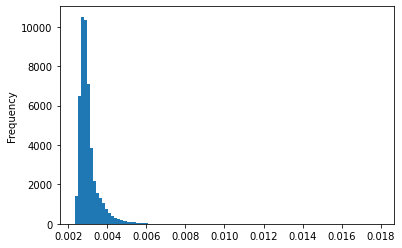

In [104]:
G = nx.from_pandas_adjacency(pd.DataFrame(data=fused_network, index=class_df.index.values, columns=class_df.index.values), create_using=nx.Graph())
nx.to_pandas_edgelist(G)['weight'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

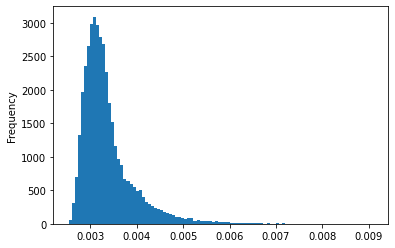

In [98]:
G = nx.from_pandas_adjacency(pd.DataFrame(data=fused_network, index=class_df.index.values, columns=class_df.index.values), create_using=nx.Graph())
nx.to_pandas_edgelist(G)['weight'].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

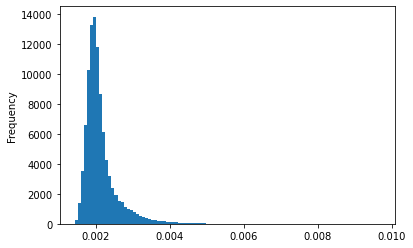

In [101]:
G = nx.from_pandas_adjacency(pd.DataFrame(data=fused_network, index=class_df.index.values, columns=class_df.index.values), create_using=nx.Graph())
nx.to_pandas_edgelist(G)['weight'].plot.hist(bins=100)

In [4]:
cancer = "COAD"
base = f"C:/Users/colombelli/Desktop/TCC/experiments/{cancer}/"

df = pd.read_csv(f"{base}{cancer}_mRNA.csv", index_col=0).T
class_df = build_class_df(list(df.index), agglutinate_stages=False).dropna()
df = df.loc[class_df.index, :]
corr_df1 = get_correlation_dataframe(df) 

100%|████████████████████████████████████████████████████████████████████████████████| 282/282 [00:03<00:00, 91.09it/s]


In [15]:
df = pd.read_csv(f"{base}{cancer}_miRNA.csv", index_col=0).T
df = df.loc[class_df.index, :]
corr_df2 = get_correlation_dataframe(df)

df = pd.read_csv(f"{base}{cancer}_Methy.csv", index_col=0).T
df = df.loc[class_df.index, :]
corr_df3 = get_correlation_dataframe(df)

100%|████████████████████████████████████████████████████████████████████████████████| 282/282 [00:03<00:00, 90.69it/s]


In [25]:
np.unique(np.argmax(np.array([corr_df1.r, corr_df2.r, corr_df3.r]), axis=0), return_counts=True)

(array([0, 1, 2], dtype=int64), array([12617, 13495, 13791], dtype=int64))

In [39]:
greatest_r = np.argmax(np.array([corr_df1.r, corr_df2.r, corr_df3.r]), axis=0)
pd.concat([corr_df1.loc[greatest_r == 0], corr_df2.loc[greatest_r == 1], corr_df3.loc[greatest_r == 2]]).sort_index()

,sample1,sample2,r,p
0,TCGA.3L.AA1B.01,TCGA.3L.AA1B.01,1.000000,0.000000e+00
1,TCGA.3L.AA1B.01,TCGA.4N.A93T.01,0.246780,4.270704e-04
2,TCGA.3L.AA1B.01,TCGA.4T.AA8H.01,0.047652,3.309244e-02
3,TCGA.3L.AA1B.01,TCGA.5M.AAT4.01,0.031085,6.621425e-01
4,TCGA.3L.AA1B.01,TCGA.5M.AAT6.01,0.261240,1.456921e-32
...,...,...,...,...
39898,TCGA.SS.A7HO.01,TCGA.T9.A92H.01,0.174986,3.232647e-15
39899,TCGA.SS.A7HO.01,TCGA.WS.AB45.01,0.058950,4.070064e-01
39900,TCGA.T9.A92H.01,TCGA.T9.A92H.01,1.000000,0.000000e+00
39901,TCGA.T9.A92H.01,TCGA.WS.AB45.01,-0.146645,3.825682e-02


In [37]:
merge_correlation_dataframes([corr_df1, corr_df2, corr_df3])

,sample1,sample2,r,p
0,TCGA.3L.AA1B.01,TCGA.3L.AA1B.01,1.000000,0.000000e+00
1,TCGA.3L.AA1B.01,TCGA.4N.A93T.01,0.246780,4.270704e-04
2,TCGA.3L.AA1B.01,TCGA.4T.AA8H.01,0.047652,3.309244e-02
3,TCGA.3L.AA1B.01,TCGA.5M.AAT4.01,0.031085,6.621425e-01
4,TCGA.3L.AA1B.01,TCGA.5M.AAT6.01,0.261240,1.456921e-32
...,...,...,...,...
39898,TCGA.SS.A7HO.01,TCGA.T9.A92H.01,0.174986,3.232647e-15
39899,TCGA.SS.A7HO.01,TCGA.WS.AB45.01,0.058950,4.070064e-01
39900,TCGA.T9.A92H.01,TCGA.T9.A92H.01,1.000000,0.000000e+00
39901,TCGA.T9.A92H.01,TCGA.WS.AB45.01,-0.146645,3.825682e-02


In [ ]:
from skfeature.utility import construct_W

In [4]:
cancer = "COAD"
base = f"C:/Users/colombelli/Desktop/TCC/experiments/{cancer}/"
gene = pd.read_csv(f"{base}{cancer}_mRNA.csv", index_col=0)

In [5]:
gene

,TCGA.3L.AA1B.01,TCGA.4N.A93T.01,TCGA.4T.AA8H.01,TCGA.5M.AAT4.01,TCGA.5M.AAT6.01,TCGA.5M.AATE.01,TCGA.A6.2671.01,TCGA.A6.2672.01,TCGA.A6.2675.01,TCGA.A6.2677.01,...,TCGA.QG.A5YV.01,TCGA.QG.A5YW.01,TCGA.QG.A5YX.01,TCGA.QG.A5Z1.01,TCGA.QG.A5Z2.01,TCGA.QL.A97D.01,TCGA.RU.A8FL.01,TCGA.SS.A7HO.01,TCGA.T9.A92H.01,TCGA.WS.AB45.01
RPS4Y1,-1.035590,1.276498,0.641973,-0.488932,-0.446935,1.364889,0.110834,-0.083130,0.330267,-0.094889,...,-1.136451,-1.059011,-1.088005,-0.019340,1.285423,0.676344,-0.708095,-1.118551,-0.466514,0.469696
PLA2G12B,0.134160,-1.233892,-1.185981,-0.053549,-1.189513,-0.262781,-1.245440,-0.223286,0.814536,0.077590,...,0.722711,-0.196090,1.638953,0.585758,-1.185634,-1.204182,0.771165,1.271005,0.341615,-1.229306
IRX2,-1.161729,1.017097,1.811620,-1.096155,0.954336,1.037169,0.529566,0.169593,-0.978943,-0.137452,...,1.189071,-1.087309,0.051335,-1.123347,0.916396,1.851163,0.269070,1.169738,-1.131688,-0.911252
GNG4,0.804959,0.668608,-0.146531,0.123667,-0.826497,1.663274,1.462529,-0.501833,0.807896,0.091087,...,1.345180,0.444895,0.559792,1.034338,-1.301866,-0.383000,0.812885,-0.357360,0.781181,-1.391387
LINC00960,1.554203,1.183877,0.137912,-1.190119,1.182505,1.284356,-0.268431,-0.454227,-1.244976,0.063226,...,1.256058,-1.017427,0.755304,-1.264404,1.360400,1.048561,-1.373574,1.296718,-0.359932,-0.280423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MRPL18,-1.279206,0.670130,-0.587969,0.170503,0.954628,-0.636561,0.124308,-0.484742,-0.337058,-0.187890,...,0.968092,0.565546,0.558886,-1.271067,-0.870002,-0.764083,1.946830,0.421252,1.158265,-2.119467
SPN,0.388930,-1.137061,-1.218467,-1.132593,1.001027,-0.927787,-0.336330,0.218158,0.595751,-0.155436,...,-1.072951,0.276702,-0.974266,-0.615218,0.986733,0.317700,-0.916163,2.060331,-0.767384,0.885656
BICC1,0.317152,-1.472641,-1.505502,-0.998722,2.182287,-0.821735,0.081200,0.113428,1.294722,0.173864,...,-0.879645,-0.220487,-1.489088,0.614572,-1.262709,-0.930657,0.105303,-1.081674,0.875278,2.411032
ANO9,1.242822,1.555979,0.010808,1.334994,-1.154203,1.415784,1.082372,-0.076588,1.111478,-0.053631,...,1.200325,0.570548,0.396946,1.103185,0.000594,1.631416,1.404305,1.629652,0.744617,-3.373772


#### Complete pipeline

In [10]:
cancer = "KIRC"
base = f"C:/Users/colombelli/Desktop/TCC/experiments/{cancer}/"

df = pd.read_csv(f"{base}{cancer}_mRNA.csv", index_col=0).T
class_df = build_class_df(list(df.index), agglutinate_stages=False).dropna()
df = df.loc[class_df.index, :]
corr_df_mrna = get_correlation_dataframe(df) 

df = pd.read_csv(f"{base}{cancer}_miRNA.csv", index_col=0).T
df = df.loc[class_df.index, :]
corr_df_mirna = get_correlation_dataframe(df) 

df = pd.read_csv(f"{base}{cancer}_Methy.csv", index_col=0).T
df = df.loc[class_df.index, :]
corr_df_methy = get_correlation_dataframe(df) 

corr_df = merge_correlation_dataframes([corr_df_mrna, corr_df_mirna, corr_df_methy])

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 82.66it/s]


In [5]:
r_threshold = 0.7
p_threshold = 0.05

get_consistency_index(build_edge_list(corr_df, r_threshold, p_threshold), class_df)

0.9845201238390093

In [18]:
save_dir = base+"stage_1_2_3_4/07_005/"
generate_csvs(build_edge_list(corr_df, r_threshold, p_threshold), class_df, max_each_feature=100)

#### Automatic various thresholds network creation

In [40]:
cancers = ["COAD", "KIRC", "LUAD"]
r_thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] 

for cancer in cancers:
    print(cancer)
    base = f"C:/Users/colombelli/Desktop/TCC/experiments/{cancer}/"

    df = pd.read_csv(f"{base}{cancer}_mRNA.csv", index_col=0).T
    class_df = build_class_df(list(df.index), agglutinate_stages=False).dropna()
    df = df.loc[class_df.index, :]
    corr_df_mrna = get_correlation_dataframe(df) 

    df = pd.read_csv(f"{base}{cancer}_miRNA.csv", index_col=0).T
    df = df.loc[class_df.index, :]
    corr_df_mirna = get_correlation_dataframe(df) 

    df = pd.read_csv(f"{base}{cancer}_Methy.csv", index_col=0).T
    df = df.loc[class_df.index, :]
    corr_df_methy = get_correlation_dataframe(df) 

    corr_df = merge_correlation_dataframes([corr_df_mrna, corr_df_mirna, corr_df_methy])
    
    # Write class counts and their weights for the categorical cross entropy
    n_samples = len(class_df)
    n_classes = 4
    with open(f"{base}class_info.txt", 'w') as f:
        print("class\t | #\t| weight", file=f)
        for i, count in class_df.value_counts().items():
            weight = n_samples / (n_classes * count)
            print(i[0], "\t |", count, "\t| ", weight, file=f)
    
    
    for r in r_thresholds:
        print(r)
        save_dir = f"{base}thresholds_2/{str(r).replace('.', '')}_005/"
        generate_csvs(build_edge_list(corr_df, r, 0.05), class_df, max_each_feature=999999)
    print("\n\n")

COAD


100%|████████████████████████████████████████████████████████████████████████████████| 282/282 [00:03<00:00, 91.55it/s]


0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8



KIRC


100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 79.24it/s]


0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8



LUAD


100%|████████████████████████████████████████████████████████████████████████████████| 445/445 [00:08<00:00, 54.45it/s]


0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8





### Automatic threshold network creation with SNF

In [108]:
cancers = ["COAD", "KIRC", "LUAD"]
thresholds = {
    "COAD": [0.0025, 0.0030, 0.0035, 0.0040, 0.0045],
    "KIRC": [0.0025, 0.0030, 0.0035, 0.0040, 0.0045],
    "LUAD": [0.0015, 0.0020, 0.0025, 0.0030, 0.0035]
    }

for cancer in cancers:
    print(cancer)
    base = f"C:/Users/colombelli/Desktop/TCC/experiments/{cancer}/"

    dfs_values = []

    df1 = pd.read_csv(f"{base}{cancer}_mRNA.csv", index_col=0).T
    class_df = build_class_df(list(df1.index), agglutinate_stages=False).dropna()
    dfs_values.append(df1.loc[class_df.index, :].values)

    df2 = pd.read_csv(f"{base}{cancer}_miRNA.csv", index_col=0).T
    dfs_values.append(df2.loc[class_df.index, :].values)

    df3 = pd.read_csv(f"{base}{cancer}_Methy.csv", index_col=0).T
    dfs_values.append(df3.loc[class_df.index, :].values)
    
    graph_df = get_snf_network(dfs_values, class_df)
    
    # Write class counts and their weights for the categorical cross entropy
    n_samples = len(class_df)
    n_classes = 4
    with open(f"{base}class_info.txt", 'w') as f:
        print("class\t | #\t| weight", file=f)
        for i, count in class_df.value_counts().items():
            weight = n_samples / (n_classes * count)
            print(i[0], "\t |", count, "\t| ", weight, file=f)
    
    
    for th in thresholds[cancer]:
        print(th)
        save_dir = f"{base}snf/{str(th).replace('.', '')}/"
        generate_csvs(filter_relevant_connections(graph_df, th), class_df, max_each_feature=999999)
    print("\n\n")

COAD
0.0025
0.003
0.0035
0.004
0.0045



KIRC
0.0025
0.003
0.0035
0.004
0.0045



LUAD
0.0015
0.002
0.0025
0.003
0.0035





#### Calculate alpha weights for focal loss

In [19]:
n_samples = len(class_df)
n_classes = 4
print("class\t | #\t| weight")
for i, count in class_df.value_counts().items():
    weight = n_samples / (n_classes * count)
    print(i[0], "\t |", count, "\t| ", weight)

class	 | #	| weight
stage1 	 | 244 	|  0.45594262295081966
stage2 	 | 109 	|  1.0206422018348624
stage3 	 | 73 	|  1.523972602739726
stage4 	 | 19 	|  5.855263157894737


### PMLB datasets

In [19]:
def get_correlation_dataframe(df):
    col_1 = []
    col_2 = []
    col_r = []
    col_p = []

    for idx1, row1 in tqdm(df.iterrows(), total=df.shape[0]):
        for idx2, row2 in df.loc[idx1:, :].iterrows():
            r, p = stats.pearsonr(row1.values, row2.values)
            col_1.append(idx1)
            col_2.append(idx2)
            col_r.append(r)
            col_p.append(p)
            
    corr_df = pd.DataFrame.from_dict({
        "sample1": col_1,
        "sample2": col_2,
        "r": col_r,
        "p": col_p
    })
    return corr_df


def build_edge_list(df, r_filter, p_filter):
    edges_df = df.loc[(df.r >= r_filter) & (df['p'] <= p_filter)]
    return edges_df.rename(columns={'sample1':'source', 'sample2':'target'})


def get_stage_class_from_patient(patient_idx, clin_df, agglutinate_stages=False):
    stage_str = clin_df.loc[patient_idx, "pathologic_stage"]
    
    if stage_str in ["stage i"+suffix for suffix in ['', 'a','b','c']]:
        return "stage1"
    elif stage_str in ["stage ii"+suffix for suffix in ['', 'a','b','c']]:
        if agglutinate_stages:
            return "stage23"
        else:
            return "stage2"
    elif stage_str in ["stage iii"+suffix for suffix in ['', 'a','b','c']]:
        if agglutinate_stages:
            return "stage23"
        else:
            return "stage3"
    elif stage_str in ["stage iv"+suffix for suffix in ['', 'a','b','c']]:
        return "stage4"
    else:
        return np.nan


def build_class_df(df):    
    return pd.DataFrame.from_dict({
            "id": list(df.index),
            "class": df.target.values
        }).set_index("id")


def get_consistency_index(corr_df, class_df):
    correct_connections = 0
    for index, row in corr_df.iterrows():
        src_class = class_df.loc[row[0], "class"]
        trg_class = class_df.loc[row[1], "class"]
        
        if src_class == trg_class:
            correct_connections += 1
    return correct_connections/len(corr_df)


def generate_csvs(edges_df, class_df, features_df):
    edges_df.to_csv(save_dir+"edges.csv", index=False)
    class_df.to_csv(save_dir+"classes.csv", index=True)
    features_df.to_csv(save_dir+"features.csv", index=True)
    return

In [14]:
from pmlb import fetch_data

base = "C:/Users/colombelli/Desktop/TCC/data/PMLB/waveform_40/"
save_dir = base
dataset = "waveform_40"

df = fetch_data(dataset)
class_df = build_class_df(df).dropna()
df = df.loc[class_df.index, :]
corr_df = get_correlation_dataframe(df.iloc[:, :-1])  # Remove 'target' column, which have the classes information

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [14:07<00:00,  5.90it/s]


In [35]:
r_threshold = 0.8
p_threshold = 0.05

edge_list = build_edge_list(corr_df, r_threshold, p_threshold)

In [36]:
get_consistency_index(edge_list, class_df)

0.7237635928564169

In [40]:
save_dir = base+"r08/"
generate_csvs(edge_list, class_df, df.iloc[:, :-1])

In [28]:
class_df.value_counts()

class
0        1692
2        1655
1        1653
dtype: int64